# Layered examples
*Author: Niels Jeppesen (niejep@dtu.dk)*

Load essential modules for loading and showing data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

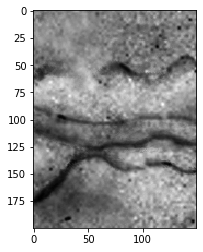

In [2]:
# Load data.
path = './data/layers.png'
data = imread(path).astype(np.int32)

# Show image.
plt.imshow(data, cmap='gray')
plt.show()

## Detect one layer

In [3]:
from slgbuilder import GraphObject, MaxflowBuilder

Let's create an object that represent the layer we're trying a segment. Here we are only segmenting one layer. The image data is passed directly to the ```GraphObject```. By default, it assumes data is structured on a regular index grid.

In [4]:
layer_1 = GraphObject(data)

Next we create the ```MaxflowBuilder``` and add the layer. Then we add layered cost and smoothness. Edges are added automatically for when calling ```add_layered_boundary_cost``` and ```add_layered_smoothness```. By default these edges are added for all object previously added to the ```MaxflowBuilder```. However, it is possible to add the edges for specific object only, by passing a list of objects to the function. The graph structure is based on [Li et al](https://doi.org/10.1109/TPAMI.2006.19).

In [5]:
helper = MaxflowBuilder()
helper.add_object(layer_1)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness()

The graph is cut using the [Maxflow](https://github.com/Skielex/maxflow) algorithm to get the maximum flow/minimum cut. This algorithm will find the global optimal solution to the binary segmentation problem. 

In [6]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 115421


Get segmentation for layer 1 and display it.

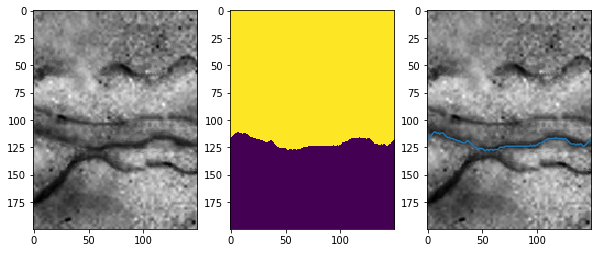

In [7]:
segmentation = helper.what_segments(layer_1)
segmentation_line = np.argmin(segmentation, axis=0)

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(data, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(segmentation)
ax = plt.subplot(1, 3, 3)
ax.imshow(data, cmap='gray')
ax.plot(segmentation_line)
plt.show()

## Detect multiple layers

This time we will create four objects, as we want to segment four different layers. Although our graph cut is still binary, we will create the graph so that we get a multi-label segmentation.

In [8]:
layers = []
for i in range(4):
    layers.append(GraphObject(data))

We create the ```MaxflowBuilder``` and add all layers to the graph. We then add boundary costs and smoothness as before. This time we specify the smoothness (```delta```) to allow less smooth surfaces than before (default: ```delta = 1```).

In [9]:
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

We've added the layers to the graph, but because they all are based on the same data, and there are no interaction contraints between the layers, they would all result in the exact same segmentation. This is *not* what we want.
We want the layers to be separated by a certain distance. Luckily, [Li et al](https://doi.org/10.1109/TPAMI.2006.19). describe how to enforce a minimum distance between the layers. This technique has been implemented in ```add_layered_containment```, which takes an *outer* and an *inner* ```GraphObject``` and lets you specify both a minimum and maximum distance/margin between them. In this case we will only specify a minimum margin.

Let's add the interactions and call ```maxflow```.

In [10]:
for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)    

In [11]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 470405


We can now get the segmentations for all layers and show them. Notice that the blue line, representing the first layers is the furthest down, or outermost.

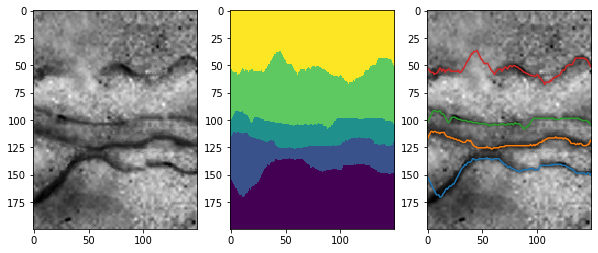

In [12]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(data, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.sum(segmentations, axis=0))
ax = plt.subplot(1, 3, 3)
ax.imshow(data, cmap='gray')
for line in segmentation_lines:
    ax.plot(line)
plt.show()

Here we segmenting 2D images, but the ```slgbuilder``` module actually supports N-D data. If ```data``` was a 3D ```ndarray``` the code would still work 'as is'. The surfaces are always found on the first axis of the input data.

As an example lets create a small volume from the same data as before and segment it.

Volume shape: (200, 150, 4)


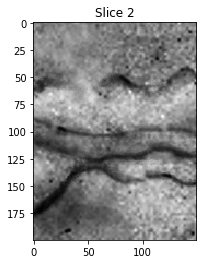

In [13]:
# Create volume from data, by simply repeating data.
data_vol = np.repeat(data[..., np.newaxis], 4, axis=-1)

print('Volume shape:', data_vol.shape)
ax = plt.subplot(1, 1, 1, title='Slice 2')
ax.imshow(data_vol[..., 2], cmap='gray')
plt.show()

In [14]:
layers = []
for i in range(4):
    layers.append(GraphObject(data_vol))
    
helper = MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)  

for i in range(len(layers)-1):
    helper.add_layered_containment(layers[i], layers[i+1], min_margin=10)

In [15]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 1881620


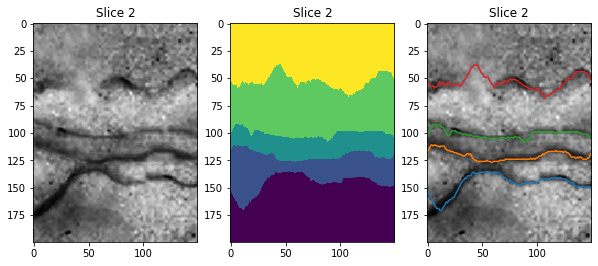

In [16]:
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s[..., 2], axis=0) for s in segmentations]

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1, title='Slice 2')
ax.imshow(data_vol[..., 2], cmap='gray')
ax = plt.subplot(1, 3, 2, title='Slice 2')
ax.imshow(np.sum(segmentations, axis=0)[..., 2])
ax = plt.subplot(1, 3, 3, title='Slice 2')
ax.imshow(data_vol[..., 2], cmap='gray')
for line in segmentation_lines:
    ax.plot(line)
plt.show()

The segmentation is of course the same a before for each slice, as we used the same image to create each slice of the volume. The flow is now just four times more, as we stacked up four images. Segmentation time and graph size is naturally also increased.